# Functions and imports

In [1]:
# Imports
from util import *
from bqm_operations import *
from embedding_operations import *
import dimod
import pandas as pd
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
from minorminer import find_embedding
import scipy
import csv
import subprocess
import os
import math

## get_emb_info

In [2]:
def get_emb_info(emb:dict):
  '''
    Given an embedding returns the average chain length, maximum chain length and the number of qubits used.
  '''
  total_num_qubits = 0
  num_variables = 0
  max_chain_length = 0 
  for var, chain in emb.items():
    if len(chain) > max_chain_length:
      max_chain_length = len(chain)
    total_num_qubits += len(chain)
    num_variables += 1
  
  return total_num_qubits / num_variables, max_chain_length, total_num_qubits

## get_good_embedding()

In [3]:
def get_good_embedding(bqm_graph:nx.Graph, sampler_graph: nx.Graph, num_tries:int=10)->dict:
  '''
    generates num_tries many embeddings and returns the one with the minimum number of qubits and m
  '''
  
  embs = []
  for _ in range(num_tries):
    emb = find_embedding(bqm_graph, sampler_graph)
    embs.append(emb)
  
  # calculate the normalization factors for each parameter
  max_num_qubits_used = 0 
  max_average_chain_length = 0
  max_std_chain_length = 0
  for emb in embs:
    chain_lengths = [len(chain) for chain in emb.values()]
    total_num_qubits = np.sum(chain_lengths)

    if total_num_qubits > max_num_qubits_used:
      max_num_qubits_used = total_num_qubits

    average_chain_length = np.mean(chain_lengths)
    if average_chain_length > max_average_chain_length:
      max_average_chain_length = average_chain_length

    std_chain_length = np.std(chain_lengths)
    if std_chain_length > max_std_chain_length:
      max_std_chain_length = std_chain_length
    
  # let's calculate each embeddings score now
  emb_scores = []
  for emb in embs:
    chain_lengths = [len(chain) for chain in emb.values()]
    total_num_qubits = np.sum(chain_lengths) / max_num_qubits_used
    average_chain_length = np.mean(chain_lengths) / max_average_chain_length
    std_chain_length = np.std(chain_lengths) / max_std_chain_length
    emb_scores.append(total_num_qubits+average_chain_length+std_chain_length)
  
  best_emb_index = np.argmin(emb_scores)
  #print(emb_scores[best_emb_index])
  #return embs[best_emb_index]
  return np.min(emb_scores)

## parse_qubo_file()

In [4]:
def parse_qubo_file(file_path):
    """Parse the QUBO file and return the QUBO instance details."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_qubits = 0
    S = ""
    C = 0
    qubo_entries = []
    qubo_started = False
    for line in lines:
        if line.startswith("QUBO"):
            qubo_started = True
            continue
        if qubo_started:
            if line.startswith("QUBITS"):
                num_qubits = int(line.split(" ")[1].strip())
            elif line.startswith("S"):
                S = line.split(" ")[1].strip()
            elif line.startswith("C"):
                C = -float(line.split(" ")[1].strip())
            elif line.strip() and line[0].isdigit():
                parts = line.split()
                i, j, J_ij = int(parts[0]), int(parts[1]), float(parts[2])
                qubo_entries.append((i, j, J_ij))
        
    return num_qubits, S, C, qubo_entries

def create_bqm_from_qubo(file_path):
    '''
        Given the file_path for a problem instance returns the BQM, ground_state, ground_state_energy
    '''
    num_qubits, S_str, C, qubo_entries = parse_qubo_file(file_path)
    bqm = dimod.BinaryQuadraticModel('BINARY')

    for i, j, J_ij in qubo_entries:
        if i == j:
            bqm.add_linear(i, J_ij)
        else:
            bqm.add_quadratic(i, j, J_ij)
    S_str = S_str[-1::-1]
    S = {var: int(S_str[var]) for var in range(num_qubits)}

    if bqm.energy(S) != C:
        print(f"Discrepancy in energy calculation: expected {C}, got {bqm.energy(S)}")

    return bqm, S, C

# Example usage:
# bqm, S, C = create_bqm_from_qubo("path_to_your_file.txt")
# print("BQM created, solution state S and ground state energy C extracted.")


## print_emb_info()

In [5]:
def print_emb_info(emb:dict):
  '''
    Given an embedding prints the average chain length, maximum chain length and the number of qubits used.
  '''
  total_num_qubits = 0
  num_variables = 0
  max_chain_length = 0 
  for var, chain in emb.items():
    if len(chain) > max_chain_length:
      max_chain_length = len(chain)
    total_num_qubits += len(chain)
    num_variables += 1
  
  print(f"Maximum chain length = {max_chain_length}")
  print(f"Average chain length = {total_num_qubits / num_variables}")
  print(f"Total num qubits = {total_num_qubits}")
  

## draw_copied_bqm

In [6]:

def draw_copied_bqm(copied_bqm: dimod.BinaryQuadraticModel, org_bqm: dimod.BinaryQuadraticModel, return_graph:bool=False, node_size:int=500, font_size: int=12):
    # Convert original BQM to a NetworkX graph
    G_org = dimod.to_networkx_graph(org_bqm)

    # Get positions for the original graph nodes
    pos_original = nx.circular_layout(G_org)  # Can use different layouts if more suitable

    # Initialize new positions dictionary and color map for the copied variables
    pos_copied = {}
    color_map = []

    # Calculate new positions for each copied variable
    for i, center_pos in pos_original.items():
        # Calculate offsets for the triangle positions
        offset_left = np.array([-0.1, 0.1])  # Adjust the offset as needed
        offset_right = np.array([0.1, 0.1])  # Adjust the offset as needed

        # Assign positions to the copied variables and their colors
        pos_copied[f'0_{i}'] = center_pos
        color_map.append('red')  # Color for '0_i'

        pos_copied[f'1_{i}'] = center_pos + offset_left
        color_map.append('green')  # Color for '1_i'

        pos_copied[f'2_{i}'] = center_pos + offset_right
        color_map.append('blue')  # Color for '2_i'

    # Construct G_copied from copied BQM
    G_copied = dimod.to_networkx_graph(copied_bqm)

    # Set the 'pos' attribute for each node in G_copied
    nx.set_node_attributes(G_copied, pos_copied, 'pos')

    # Draw the copied graph
    plt.figure(figsize=(8, 8))
    nx.draw(G_copied, pos=nx.get_node_attributes(G_copied, 'pos'), with_labels=True, node_color=color_map, node_size=node_size, font_size=font_size)
    plt.show()

    # Check if the graphs are isomorphic (optional)
    if not nx.is_isomorphic(dimod.to_networkx_graph(copied_bqm), G_copied):
        print("\n The generated graphs are NOT isomorphic!!\n")

    # Return the graph if requested
    if return_graph:
        return G_copied


## get_min_energy()

In [7]:
def get_min_energy(path):
  '''
    path: complete path for the problem file
    return: minimum energy for this problem as stored in gs_energies of the repository
  '''
  # get the path to gs_energies file in the same path
  path_energies = "/".join(path.split('/')[:-1]) + '/gs_energies.txt'
  # get the name of the current file
  filename = path.split('/')[-1]
  # get the energy of the current file from the gs_energies.txt
  with open(path_energies) as f_energies:
    for line in f_energies.read().splitlines():
      fname, energy = line.split('\t')
      if fname == filename:
        return float(energy)

## run_EC_generator()

In [8]:
def run_EC_generator(maincpp_directory: str, NUM_TOTAL_SETS: int, NUM_SOLUTION_SETS: int, seed:int=0, PROB_MIN: float = 0.2, PROB_MAX: float = 0.5, NUM_ELEMENTS:int=63, USE_CUSTOM_PROB_SET_BIT:bool =False):
    # Construct the path to main.cpp based on the provided directory
    main_cpp_path = os.path.join(maincpp_directory, "main.cpp")
    
    # Read the current content of main.cpp
    with open(main_cpp_path, "r") as file:
        lines = file.readlines()
    
    # Modify the lines where the variables are defined
    new_lines = []
    for line in lines:
        if "constexpr ULL SEED" in line:
            new_lines.append(f"constexpr ULL SEED = {seed};\n")
        elif "constexpr UL NUM_TOTAL_SETS" in line:
            new_lines.append(f"constexpr UL NUM_TOTAL_SETS = {NUM_TOTAL_SETS};\n")
        elif "constexpr UL NUM_SOLUTION_SETS" in line:
            new_lines.append(f"constexpr UL NUM_SOLUTION_SETS = {NUM_SOLUTION_SETS};\n")
        elif "constexpr UL NUM_ELEMENTS" in line:
            new_lines.append(f"constexpr UL NUM_ELEMENTS = {NUM_ELEMENTS};\n")
        elif "constexpr bool USE_CUSTOM_PROB_SET_BIT" in line:
            if USE_CUSTOM_PROB_SET_BIT:
                new_lines.append(f"constexpr bool USE_CUSTOM_PROB_SET_BIT = true;\n")
            else:
                new_lines.append(f"constexpr bool USE_CUSTOM_PROB_SET_BIT = false;\n")
        elif "constexpr double PROB_MIN" in line:
            new_lines.append(f"constexpr double PROB_MIN = {PROB_MIN};\n")
        elif "constexpr double PROB_MAX" in line:
            new_lines.append(f"constexpr double PROB_MAX  = {PROB_MAX};\n")
        else:
            new_lines.append(line)
    
    # Write the modified content back to main.cpp
    with open(main_cpp_path, "w") as file:
        file.writelines(new_lines)
    
    # Change to the directory where main.cpp is located
    os.chdir(maincpp_directory)
    
    # Define the output file path based on function parameters
    if USE_CUSTOM_PROB_SET_BIT:
        output_file_path = f"./Exact_Cover/NTS|{NUM_TOTAL_SETS}_NSS|{NUM_SOLUTION_SETS}_seed|{seed}_{PROB_MIN, PROB_MAX}.txt"
    else:
        output_file_path = f"./Exact_Cover/NTS|{NUM_TOTAL_SETS}_NSS|{NUM_SOLUTION_SETS}_seed|{seed}.txt"
    # Prepare output directory and file
    output_directory = f"./Exact_Cover"
    os.makedirs(output_directory, exist_ok=True)
    
    # Compile the modified main.cpp and capture output
    with open(output_file_path, 'w') as output_file:
        subprocess.run(['make'], stdout=output_file, stderr=subprocess.STDOUT)
    
    return output_file_path

# Calculating the success rates for various problem parameters

The parameters I will check for problem generation are:
- NUM_TOTAL_SETS : from `[5,10,15,20,25,30,35,40,45,50,55,60]`
- NUM_SOLUTION_SETS : I think it makes more sense to do this like fractions of NUM_TOTAL_SETS. these fractions could be 1/3,1/4,1/5,1/6,1/10
- I will always keep NUM_ELEMENTS at 63. 
- I can also change USE_CUSTOM_PROB_SET_BIT to true and then set PROB_MIN, PROB_MAX to (0.2,0.5), (0.1, 0.4), (0.1, 0.3), (0.1, 0.2).

I will do one problem instance for each case with `AT=0.5` and then maybe `AT=2` with `num_reads=200`. This should give some ideas regarding the success rates.


## USE_CUSTOM_PROB_SET_BIT = False

In [14]:
maincpp_dir = '/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main'
NTSs = [5,10,15,20,25,30,35,40]
fractions = [1/4, 1/5, 1/6]
ATs = [1]
num_reads = 500

In [13]:
sampler = DWaveSampler(solver_id='Advantage_system5.4')
sampler_graph = sampler.to_networkx_graph()

In [15]:
# construct all the problems
BQMs = {}
gs_energies = {}
for NTS in NTSs:
  BQMs[NTS] = {}
  gs_energies[NTS] = {}
  for fraction in fractions:
    problem_path = run_EC_generator(maincpp_directory=maincpp_dir, 
                                    NUM_TOTAL_SETS=NTS, 
                                    NUM_SOLUTION_SETS=math.ceil(NTS*fraction))
    bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)
    BQMs[NTS][fraction] = bqm
    gs_energies[NTS][fraction] = gs_energy

In [17]:
# find embeddings for all the copied problem instancces
embs = {}
for NTS in NTSs:
  embs[NTS] = {}
  print(NTS)
  for fraction in fractions:
    bqm = BQMs[NTS][fraction]
    copied_bqm = copy_BQM(bqm, gamma=0)
    copied_bqm_graph = dimod.to_networkx_graph(copied_bqm)

    embs[NTS][fraction] = find_embedding(copied_bqm_graph, sampler_graph)

5
10
15
20
25
30
35
40


In [60]:
with open("./exact_cover_embs.json", 'w') as f:
  json.dump(embs, f)

In [18]:
# for each fraction let's sample all the problems
results = {}
for AT in [5]:
  results[AT] = {}
  for fraction in fractions:
    results[AT][fraction] = {}
    for NTS in NTSs:
      bqm = BQMs[NTS][fraction]
      copied_bqm = copy_BQM(bqm, gamma=0)

      emb = embs[NTS][fraction]
      emb_sampler = FixedEmbeddingComposite(sampler, emb)
      res = emb_sampler.sample(copied_bqm, annealing_time=AT, num_reads=num_reads )
      results[AT][fraction][NTS] = res

In [23]:
results.keys()

dict_keys([5])

In [24]:
# calculate CSRS
csrs = {} 
to_skip = []
for AT in [5]:
  csrs[AT] = {}
  print(AT)
  for fraction in fractions:
    csrs[AT][fraction] = {}
    for NTS in NTSs:
      org_bqm = BQMs[NTS][fraction]
      if len(org_bqm.variables) == 0:
        print(f"no BQM for {fraction}, {NTS}, {AT}")
        csrs[AT][fraction][NTS] = -1
        to_skip.append((NTS,fraction))
        continue
      min_energy = gs_energies[NTS][fraction]
      csrs[AT][fraction][NTS] = get_combined_success_rate(org_bqm, 
                                                          results[AT][fraction][NTS],
                                                          min_energy=min_energy)[0]
      

5
no BQM for 0.2, 5, 5
no BQM for 0.16666666666666666, 5, 5


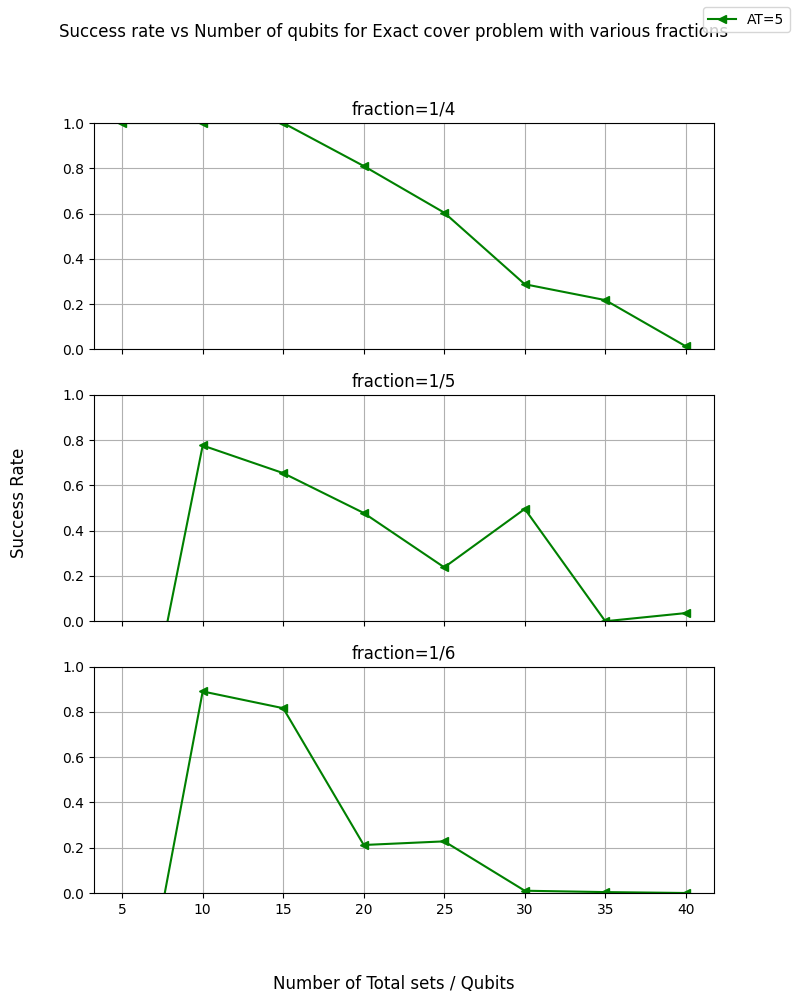

In [26]:
# plot the CSRS
# x axis will be the number of qubits / Number of total sets 
# y axis is going to be the success rate
# there will be two lines in each figure once for each AT
# there will be len(fractions) many subfigures
figure, axs = plt.subplots(len(fractions), 1, figsize=(8,10), sharex=True)

markers = {0.5:'o', 2:'x', 5:'<'}
colors = {0.5:'r', 2:'b', 5:'g'}

for indx, fraction in enumerate(fractions):
  axs[indx].set_title(f"fraction=1/{int(1/fraction)}")
  axs[indx].grid()
  axs[indx].set_ylim(0,1)
  for AT in [5]:
    x_axis = NTSs
    y_axis = [csrs[AT][fraction][NTS] for NTS in NTSs]
    if indx == 0:
      axs[indx].plot(x_axis, 
                   y_axis,
                   marker=markers[AT],
                   color=colors[AT],
                   label=f"AT={AT}"
                   )
    else:
      axs[indx].plot(x_axis, 
                   y_axis,
                   marker=markers[AT],
                   color=colors[AT]
                   )
  
figure.supxlabel("Number of Total sets / Qubits")
figure.supylabel("Success Rate")
figure.suptitle(f"Success rate vs Number of qubits for Exact cover problem with various fractions")
figure.legend()

## USE_CUSTOM_PROB_SET_BIT = True



In [37]:
maincpp_dir = '/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main'
PROBS =  [(0.1,0.4), (0.2, 0.5), (0.3,0.6), (0,0)]
NTSs = [6,12,18,24,32,36,42]
fractions = [1/3, 1/6]
# for some reason we get an error if NSS < 0 when prob_min/prob_max thingy is not used
min_NSS = 2
AT = 5
num_reads = 1000

In [32]:
sampler = DWaveSampler(solver_id='Advantage_system5.4')
sampler_graph = sampler.to_networkx_graph()

In [33]:
# construct all the problems
BQMs = {}
gs_energies = {}
for NTS in NTSs:
  BQMs[NTS] = {}
  gs_energies[NTS] = {}
  for probs in PROBS:
    if NTS in BQMs and probs in BQMs[NTS]:
      continue
    if probs == (0,0):
      problem_path = run_EC_generator(maincpp_directory=maincpp_dir, 
                                      NUM_TOTAL_SETS=NTS, 
                                      NUM_SOLUTION_SETS=math.ceil(NTS*fraction),
                                      USE_CUSTOM_PROB_SET_BIT=False)
      bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)
      BQMs[NTS][(0,0)] = bqm
      gs_energies[NTS][(0,0)] = gs_energy
    else:
      prob_min, prob_max = probs
      problem_path = run_EC_generator(maincpp_directory=maincpp_dir, 
                                      NUM_TOTAL_SETS=NTS, 
                                      NUM_SOLUTION_SETS=math.ceil(NTS*fraction),
                                      PROB_MIN=prob_min,
                                      PROB_MAX=prob_max,
                                      USE_CUSTOM_PROB_SET_BIT=True)
      bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)
      BQMs[NTS][(prob_min, prob_max)] = bqm
      gs_energies[NTS][(prob_min, prob_max)] = gs_energy

correct
correct
correct
correct
correct
correct
correct


In [39]:
# find embeddings for all the copied problem instancces
#embs = {}
for NTS in NTSs:
  #embs[NTS] = {}
  print(NTS)
  for probs in PROBS:
    if NTS in embs and probs in embs[NTS]:
      continue

    bqm = BQMs[NTS][probs]
    copied_bqm = copy_BQM(bqm, gamma=0)
    copied_bqm_graph = dimod.to_networkx_graph(copied_bqm)

    if probs == (0,0):
      embs[NTS][(0,0)] = find_embedding(copied_bqm_graph, sampler_graph)
      print('correct')
    else:
      print("hmmm")
      embs[NTS][probs] = find_embedding(copied_bqm_graph, sampler_graph)

6
12
18
24
correct
32
correct
36
correct
42
correct


In [41]:
# for each fraction let's sample all the problems
#results = {}

for NTS in NTSs:
  #results[NTS] = {}
  for probs in PROBS:
    if NTS in results and probs in results[NTS]:
      continue

    bqm = BQMs[NTS][probs]
    copied_bqm = copy_BQM(bqm, gamma=0)

    emb = embs[NTS][probs]
    emb_sampler = FixedEmbeddingComposite(sampler, emb)
    res = emb_sampler.sample(copied_bqm, annealing_time=AT, num_reads=num_reads)
    results[NTS][probs] = res

In [43]:
# calculate CSRS
csrs = {} 
to_skip = []
for NTS in NTSs:
  csrs[NTS] = {}
  for probs in PROBS:
    org_bqm = BQMs[NTS][probs]
    if len(org_bqm.variables) == 0:
      print(f"no BQM for {probs}, {NTS}")
      csrs[NTS][probs] = -1
      to_skip.append((NTS,probs))
      continue
    min_energy = gs_energies[NTS][probs]
    csrs[NTS][probs] = get_combined_success_rate(org_bqm, 
                                                results[NTS][probs],
                                                min_energy=min_energy)[0]


no BQM for (0, 0), 6


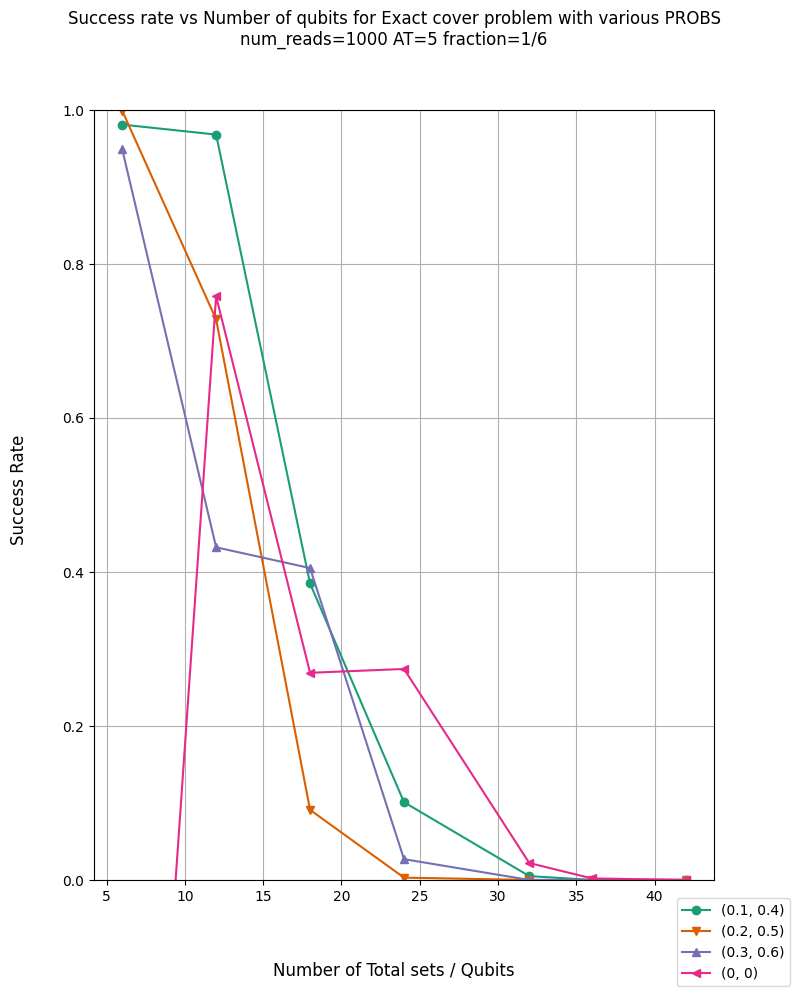

In [45]:
# plot the CSRS
# x axis will be the number of qubits / Number of total sets 
# y axis is going to be the success rate
# there will be three lines in the figure once for each PROBS
figure, ax = plt.subplots(1, 1, figsize=(8,10), sharex=True)

markers_list = get_markers(len(PROBS))
colors_list = get_colors(len(PROBS))
markers = {PROBS[i]:markers_list[i] for i in range(len(PROBS))}
colors = {PROBS[i]:colors_list[i] for i in range(len(PROBS))}

ax.grid()
ax.set_ylim(0,1)
for probs in PROBS:
  x_axis = NTSs
  y_axis = [csrs[NTS][probs] for NTS in NTSs]
  ax.plot(x_axis, 
          y_axis,
          marker=markers[probs],
          color=colors[probs],
          label=f"{probs}"
          )

figure.supxlabel("Number of Total sets / Qubits")
figure.supylabel("Success Rate")
figure.suptitle(f"Success rate vs Number of qubits for Exact cover problem with various PROBS\nnum_reads={num_reads} AT={AT} fraction=1/{int(1/fraction)}")
figure.legend(loc='lower right')

# Generate Problem Instances

Let's generate problem instances for the Exact cover problems. I will use the following set of values:

- `NUM_TOTAL_SETS` in `[6, 12, 18, 24, 32]`
- `fractions` in `[1/6]` I think this might actually be good enough.
- I have `50` instances for each problem size and I tried `50` different embedding runs to get the best 'one'.

In [21]:
maincpp_dir = '/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main'
NTSs = [6,12,18,24,32,36,42]
fraction = 1/6
ATs = [0.5, 1, 2, 3, 5]
num_reads = 500
min_NSS = 2

In [10]:
sampler = DWaveSampler(solver_id='Advantage_system5.4')
sampler_graph = sampler.to_networkx_graph()

In [11]:
# construct all the problems
BQMs = {}
gs_energies = {}
for NTS in NTSs:
  BQMs[NTS] = {}
  gs_energies[NTS] = {}

  problem_path = run_EC_generator(maincpp_directory=maincpp_dir, 
                                  NUM_TOTAL_SETS=NTS, 
                                  NUM_SOLUTION_SETS=max(math.ceil(NTS*fraction), min_NSS))
  bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)
  BQMs[NTS] = bqm
  gs_energies[NTS] = gs_energy

In [13]:
# find embeddings for all the copied problem instancces
tri_embs = {}
direct_embs = {}
copied_embs = {}
for NTS in NTSs:
  tri_embs[NTS] = {}
  direct_embs[NTS] = {}
  copied_embs[NTS] = {}
  print(NTS)

  bqm = BQMs[NTS]
  direct_bqm_graph = dimod.to_networkx_graph(bqm)
  direct_embs[NTS] = find_embedding(direct_bqm_graph, sampler_graph)

  direct_copied_bqm = copy_BQM(bqm, gamma=0, num_copies=3, copy_type='unconnected')
  direct_copied_bqm_graph = dimod.to_networkx_graph(direct_copied_bqm)
  copied_embs[NTS] = find_embedding(direct_copied_bqm_graph, sampler_graph)

  tri_copied_bqm = copy_BQM(bqm, gamma=0)
  tri_copied_bqm_graph = dimod.to_networkx_graph(tri_copied_bqm)
  tri_embs[NTS] = find_embedding(tri_copied_bqm_graph, sampler_graph)
    

6
12
18
24
32
36
42


In [22]:
# for each fraction let's sample all the problems
results = {}
for AT in ATs:
  results[AT] = {}
  for NTS in NTSs:
    results[AT][NTS] = {}
    
    bqm = BQMs[NTS]
    tri_copied_bqm = copy_BQM(bqm, gamma=0)
    direct_copied_bqm = copy_BQM(bqm, gamma=0, num_copies=3, copy_type='unconnected')

    # direct results
    emb = direct_embs[NTS]
    emb_sampler = FixedEmbeddingComposite(sampler, emb)
    res = emb_sampler.sample(bqm, annealing_time=AT, num_reads=num_reads)
    results[AT][NTS]['direct'] = res

    # copied unconnected results
    emb = copied_embs[NTS]
    emb_sampler = FixedEmbeddingComposite(sampler, emb)
    res = emb_sampler.sample(direct_copied_bqm, annealing_time=AT, num_reads=num_reads)
    results[AT][NTS]['unconnected'] = res

    # triangle copied results
    emb = tri_embs[NTS]
    emb_sampler = FixedEmbeddingComposite(sampler, emb)
    res = emb_sampler.sample(tri_copied_bqm, annealing_time=AT, num_reads=num_reads)
    results[AT][NTS]['triangle'] = res

In [23]:
# calculate CSRS
csrs = {} 
to_skip = []
for AT in ATs:
  csrs[AT] = {}
  print(AT)
  for NTS in NTSs:
    csrs[AT][NTS] = {}

    org_bqm = BQMs[NTS]
    if len(org_bqm.variables) == 0:
      print(f"no BQM for {NTS}, {AT}")
      break
    min_energy = gs_energies[NTS]
    # get direct success rate
    csrs[AT][NTS]['direct'] = get_direct_success_rate(org_bqm, 
                                              results[AT][NTS]['direct'],
                                              min_energy=min_energy)

    # get copied direct success rate
    csrs[AT][NTS]['unconnected'] = get_combined_success_rate(org_bqm, 
                                              results[AT][NTS]['unconnected'],
                                              min_energy=min_energy)[0]
    # get triangle success rate
    csrs[AT][NTS]['triangle'] = get_combined_success_rate(org_bqm, 
                                              results[AT][NTS]['triangle'],
                                              min_energy=min_energy)[0]
    

0.5
1
2
3
5


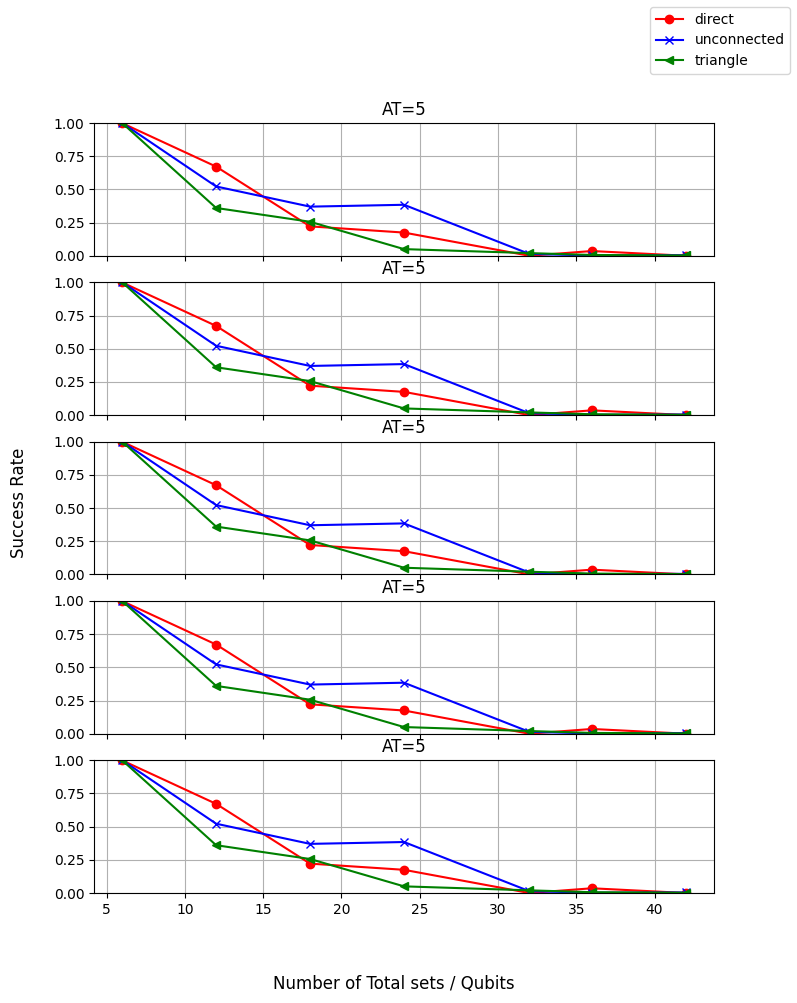

In [25]:
# plot the CSRS
# x axis will be the number of qubits / Number of total sets 
# y axis is going to be the success rate
# there will be two lines in each figure once for each AT
# there will be len(fractions) many subfigures
figure, axs = plt.subplots(len(ATs), 1, figsize=(8,10), sharex=True)

copy_types = ['direct', 'unconnected', 'triangle']

markers = {'direct':'o', 'unconnected':'x', 'triangle':'<'}
colors = {'direct':'r', 'unconnected':'b', 'triangle':'g'}

for indx, fraction in enumerate(ATs):
  axs[indx].set_title(f"AT={AT}")
  axs[indx].grid()
  axs[indx].set_ylim(0,1)
  for copy_type in copy_types:
    x_axis = NTSs
    y_axis = [csrs[AT][NTS][copy_type] for NTS in NTSs]
    if copy_type == 'direct':
      # recalculate the direct 
      new_y_axis = [1-(1-p)**3 for p in y_axis]
      y_axis = new_y_axis
    if indx == 0:
      axs[indx].plot(x_axis, 
                   y_axis,
                   marker=markers[copy_type],
                   color=colors[copy_type],
                   label=f"{copy_type}"
                   )
    else:
      axs[indx].plot(x_axis, 
                   y_axis,
                   marker=markers[copy_type],
                   color=colors[copy_type]
                   )
  
figure.supxlabel("Number of Total sets / Qubits")
figure.supylabel("Success Rate")
figure.legend()

# Running the Problems

Let me start by using 2 ms annealing time and then do a gamma sampling for one problem instance. I should also saved these results though.



In [1]:
NTSs = [6,12,18,24,32]  # number of total sets
NSSs = [2,2,3,4,6]      # number of solution sets
AT = 1
num_reads = 100
seeds = range(1, 5)
main_dir = "/Users/beratyenilen/Desktop/Thesis/CODE/exact-cover-generator-main/Exact_Cover"
sampler_id = 'Advantage_system4.1'
eu, na = 'eu-central-1', 'na-west-1'
gamma_range = [-0.5, -0.4, -0.3, -0.2, -0.1, 0. , 0.1,  0.2,  0.3,  0.4,  0.5]

In [2]:
sampler = DWaveSampler(solver=sampler_id, region=na)
sampler_graph = sampler.to_networkx_graph()

NameError: name 'DWaveSampler' is not defined

In [11]:
if sampler.properties['chip_id'] != sampler_id:
      print(sampler.properties['chip_id'], sampler_id)
      raise Exception(f"chip_id and sampler_id don't match. chip_id={sampler.properties['chip_id']}, sampler_id={sampler_id}")

In [12]:
# get the problems and the embeddings
BQMs = {}
gs_energies = {}
# tiled direct embeddings
direct_embs = {}
tri_embs = {}

for NTS, NSS in zip(NTSs,NSSs):
  BQMs[(NTS,NSS)] = {}
  gs_energies[(NTS,NSS)] = {}
  direct_embs[(NTS,NSS)] = {}
  tri_embs[(NTS,NSS)] = {}

  for seed in seeds:
    # get the problems
    problem_path = f"{main_dir}/problems/NTS|{NTS}_NSS|{NSS}_seed|{seed}.txt"
    bqm, gs, gs_energy = create_bqm_from_qubo(problem_path)
    # get direct embedding
    direct_emb_path = f"{main_dir}/embeddings/{sampler_id}/NTS|{NTS}_NSS|{NSS}_seed|{seed}_direct.json"
    with open(direct_emb_path, "r") as f:
      direct_emb = json.load(f)
    # tiled direct emb
    tiled_direct_emb = tile_minor_embedding(bqm, direct_emb, sampler_graph, max_num_tiles=3)
    tiled_bqm = copy_BQM(bqm, gamma=0, copy_type='unconnected')
    if check_embedding(tiled_bqm, tiled_direct_emb, sampler_graph):
      direct_embs[(NTS,NSS)][seed] = tiled_direct_emb
    else:
      print(f"Invalid tiled embedding for NTS,NSS={NTS,NSS} seed={seed}")

    tri_emb_path =  f"{main_dir}/embeddings/{sampler_id}/NTS|{NTS}_NSS|{NSS}_seed|{seed}_triangle.json"
    with open(tri_emb_path, "r") as f:
      tri_emb = json.load(f)

    tri_bqm = copy_BQM(bqm, gamma=0)
    if check_embedding(tri_bqm, tri_emb, sampler_graph ):
      tri_embs[(NTS,NSS)][seed] = tri_emb
    else:
      print(f"Invalid triangle embedding for NTS,NSS={NTS,NSS} seed={seed}")

    BQMs[(NTS,NSS)][seed] = bqm
    gs_energies[(NTS,NSS)][seed] = gs_energy


In [13]:
# let's run the problems and save them
for NTS,NSS in zip(NTSs, NSSs):
  print(f"NTS,NSS = {NTS, NSS}")
  for seed in seeds:
    bqm = BQMs[(NTS,NSS)][seed]
    gs_energy = gs_energies[(NTS,NSS)][seed]

    # get direct embedding
    direct_emb = direct_embs[(NTS,NSS)][seed]
    # copy bqm in unconnected manner
    copied_bqm = copy_BQM(bqm, gamma=0, num_copies=3, copy_type='unconnected')
    emb_sampler = FixedEmbeddingComposite(sampler, direct_emb)
    direct_res = emb_sampler.sample(copied_bqm, 
                                    annealing_time=AT,
                                    num_reads=num_reads)
    direct_fname = get_fname_for_results_EC(NTS, NSS, seed, problem_type='direct',
                                            solver_id=sampler_id, AT=AT, gamma=None,
                                            main_directory=main_dir)
    save_results_w_fname(direct_res, direct_fname)

    # get triangle embedding
    tri_emb = tri_embs[(NTS,NSS)][seed]
    emb_sampler = FixedEmbeddingComposite(sampler, tri_emb)
    max_strength = get_max_strength(bqm)
    for gamma in gamma_range:
      tri_bqm = copy_BQM(bqm, gamma=gamma*max_strength)
      tri_res = emb_sampler.sample(tri_bqm, 
                                 annealing_time=AT,
                                 num_reads=num_reads)
      
      tri_fname = get_fname_for_results_EC(NTS, NSS, seed, problem_type='triangle',
                                         solver_id=sampler_id, AT=AT, gamma=gamma,
                                         main_directory=main_dir)
    
      save_results_w_fname(tri_res, tri_fname)

NTS,NSS = (6, 2)
NTS,NSS = (12, 2)
NTS,NSS = (18, 3)
NTS,NSS = (24, 4)
NTS,NSS = (32, 6)
